In [3]:
!pip -q install kaggle

from google.colab import files, drive
files.upload();

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p /content/data
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset -p /content
!unzip -q -o /content/drowsiness-prediction-dataset.zip -d /content/data

import os, glob, shutil, pathlib
root = "/content/data"
act = glob.glob(root + "/**/Active Subjects", recursive=True)
fat = glob.glob(root + "/**/Fatigue Subjects", recursive=True)
if not (os.path.isdir(f"{root}/Active Subjects") and os.path.isdir(f"{root}/Fatigue Subjects")):
    if act and fat:
        a_src, f_src = act[0], fat[0]
        shutil.move(a_src, f"{root}/Active Subjects")
        shutil.move(f_src, f"{root}/Fatigue Subjects")
print("DATA_ROOT =", root, "| subdirs:", os.listdir(root))


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/rakibuleceruet/drowsiness-prediction-dataset
License(s): unknown
drowsiness-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
DATA_ROOT = /content/data | subdirs: ['Fatigue Subjects', 'Active Subjects', '0 FaceImages']


In [4]:
%%writefile /content/train_drowsiness_tf.py
import argparse, os, json, random
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def seed_everything(seed=1337):
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

def make_datasets(data_dir, img_size, batch_size, val_split, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="binary",
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    class_names = ds.class_names

    ds_size = ds.cardinality().numpy()
    val_size = int(ds_size * val_split)

    ds = ds.shuffle(buffer_size=ds_size, seed=seed, reshuffle_each_iteration=False)

    val_ds = ds.take(val_size)
    train_ds = ds.skip(val_size)

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.prefetch(AUTOTUNE)

    return train_ds, val_ds, class_names



def build_model(img_size):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3)
    )
    base.trainable = False
    inputs = keras.Input(shape=(img_size, img_size, 3))
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ])
    x = aug(inputs)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model, base


def plot_training_curves(history, outdir):
    hist = history.history
    epochs = range(1, len(hist["loss"])+1)
    plt.figure()
    plt.plot(epochs, hist["accuracy"], marker="o", label="train_acc")
    plt.plot(epochs, hist["val_accuracy"], marker="o", label="val_acc")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "training_curves_acc.png", dpi=150)
    plt.figure()
    plt.plot(epochs, hist["loss"], marker="o", label="train_loss")
    plt.plot(epochs, hist["val_loss"], marker="o", label="val_loss")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "training_curves_loss.png", dpi=150)

def plot_confusion_matrix(cm, class_names, outdir):
    import numpy as np
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label"); plt.xlabel("Predicted label"); plt.tight_layout()
    plt.savefig(outdir / "confusion_matrix.png", dpi=150)

def plot_roc(y_true, y_score, outdir):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "roc_curve.png", dpi=150)
    return roc_auc

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, required=True)
    parser.add_argument("--epochs", type=int, default=8)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--img_size", type=int, default=224)
    parser.add_argument("--val_split", type=float, default=0.15)
    parser.add_argument("--seed", type=int, default=1337)
    parser.add_argument("--out", type=str, default="/content/outputs")
    args = parser.parse_args()

    outdir = Path(args.out); outdir.mkdir(parents=True, exist_ok=True)
    seed_everything(args.seed)

    train_ds, val_ds, class_names = make_datasets(args.data_dir, args.img_size, args.batch_size, args.val_split, args.seed)
    print("Classes:", class_names)

    model, base = build_model(args.img_size)
    callbacks = [
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ModelCheckpoint(outdir / "best_model.keras", save_best_only=True, monitor="val_loss")
    ]
    history = model.fit(train_ds, epochs=args.epochs, validation_data=val_ds, callbacks=callbacks)

    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC(name="auc")])
    history_ft = model.fit(train_ds, epochs=max(2, args.epochs//2), validation_data=val_ds, callbacks=callbacks)

    plot_training_curves(history, outdir); plot_training_curves(history_ft, outdir)

    y_true, y_score = [], []
    for x, y in val_ds:
        y_true.append(y.numpy().ravel())
        y_score.append(model.predict(x, verbose=0).ravel())
    import numpy as np
    y_true = np.concatenate(y_true); y_score = np.concatenate(y_score)
    y_pred = (y_score >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, outdir)
    roc_auc = plot_roc(y_true, y_score, outdir)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    with open(outdir / "val_metrics.json", "w") as f:
        json.dump({"roc_auc": float(roc_auc), "report": report, "classes": class_names}, f, indent=2)

    model.save(outdir / "final_model.keras")
    print("Saved to:", outdir)

if __name__ == "__main__":
    main()


Writing /content/train_drowsiness_tf.py


In [12]:
import os, shutil, glob

OLD_ROOT = "/content/data"
NEW_ROOT = "/content/data_binary"

if os.path.exists(NEW_ROOT):
    shutil.rmtree(NEW_ROOT)

os.makedirs(NEW_ROOT, exist_ok=True)

for cls in ["Active Subjects", "Fatigue Subjects"]:
    matches = glob.glob(os.path.join(OLD_ROOT, "**", cls), recursive=True)
    print(cls, "->", matches)
    if not matches:
        print(f"NU am găsit folderul '{cls}' sub {OLD_ROOT}")
        continue
    src = matches[0]
    dst = os.path.join(NEW_ROOT, cls)
    shutil.copytree(src, dst)

print("\nConținut /content/data_binary:", os.listdir(NEW_ROOT))


Active Subjects -> ['/content/data/Active Subjects', '/content/data/0 FaceImages/Active Subjects']
Fatigue Subjects -> ['/content/data/Fatigue Subjects', '/content/data/0 FaceImages/Fatigue Subjects']

Conținut /content/data_binary: ['Fatigue Subjects', 'Active Subjects']


In [11]:
import os
print("content:", os.listdir("/content"))
print("data:", os.listdir("/content/data"))


content: ['.config', 'train_drowsiness_tf.py', '.ipynb_checkpoints', 'drowsiness-prediction-dataset.zip', 'data', 'kaggle.json', 'outputs_effnet', 'sample_data']
data: ['Fatigue Subjects', 'Active Subjects', '0 FaceImages']


In [13]:
DATA_DIR   = "/content/data_binary"
OUTPUT_DIR = "/content/outputs_effnet"
EPOCHS     = 8
BATCH_SIZE = 32
IMG_SIZE   = 224
VAL_SPLIT  = 0.15

!python /content/train_drowsiness_tf.py \
  --data_dir "$DATA_DIR" \
  --epochs $EPOCHS \
  --batch_size $BATCH_SIZE \
  --img_size $IMG_SIZE \
  --val_split $VAL_SPLIT \
  --out "$OUTPUT_DIR"


2025-11-23 15:14:01.327057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763910841.372707    6745 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763910841.387262    6745 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763910841.426483    6745 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763910841.426557    6745 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763910841.426568    6745 computation_placer.cc:177] computation placer alr

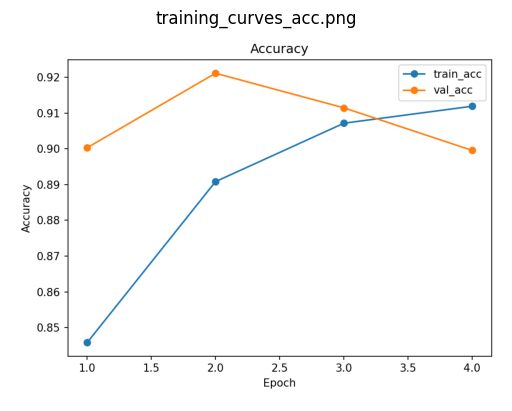

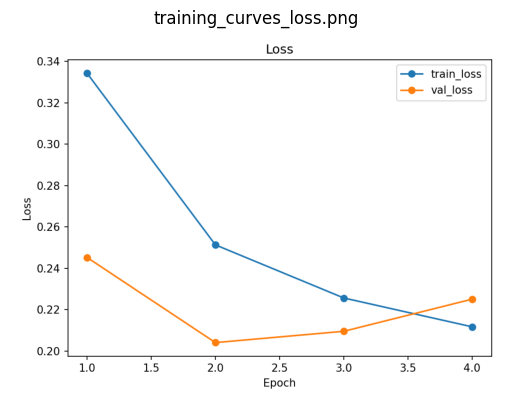

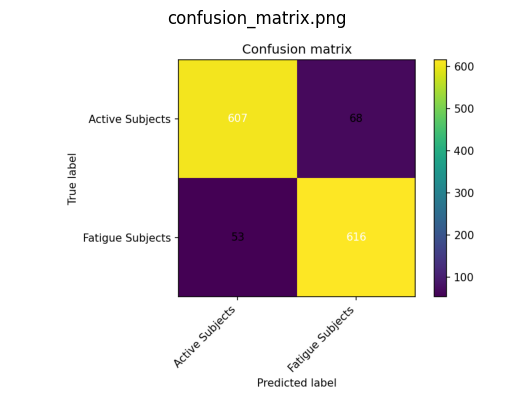

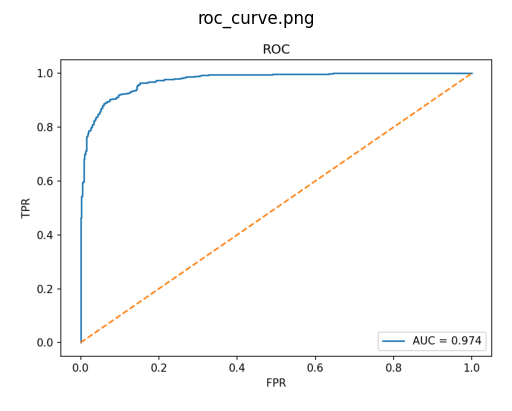

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

OUT_DIR = "/content/outputs_effnet"   # verifică să fie același ca la train

# ce grafice vrem să vedem
plots = [
    "training_curves_acc.png",
    "training_curves_loss.png",
    "confusion_matrix.png",
    "roc_curve.png",
]

for fn in plots:
    p = os.path.join(OUT_DIR, fn)
    if os.path.exists(p):
        img = mpimg.imread(p)
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(fn)
        plt.show()
    else:
        print(f"{fn} NU există în {OUT_DIR}")


In [17]:
import os, json, pprint

OUT_DIR = "/content/outputs_effnet"

metrics_path = os.path.join(OUT_DIR, "val_metrics.json")
if os.path.exists(metrics_path):
    print("=== val_metrics.json (EfficientNet) ===")
    with open(metrics_path) as f:
        metrics = json.load(f)
    pprint.pprint(metrics)
else:
    print("val_metrics.json NU există în", OUT_DIR)


=== val_metrics.json (EfficientNet) ===
{'classes': ['Active Subjects', 'Fatigue Subjects'],
 'report': {'Active Subjects': {'f1-score': 0.9093632958801499,
                                'precision': 0.9196969696969697,
                                'recall': 0.8992592592592593,
                                'support': 675.0},
            'Fatigue Subjects': {'f1-score': 0.9105691056910569,
                                 'precision': 0.9005847953216374,
                                 'recall': 0.9207772795216741,
                                 'support': 669.0},
            'accuracy': 0.9099702380952381,
            'macro avg': {'f1-score': 0.9099662007856033,
                          'precision': 0.9101408825093036,
                          'recall': 0.9100182693904667,
                          'support': 1344.0},
            'weighted avg': {'f1-score': 0.9099635092458468,
                             'precision': 0.91018354361282,
                             'recal